# Autoencoder

Based on https://lilianweng.github.io/posts/2018-08-12-vae/

**Autocoder is invented to reconstruct high-dimensional data using a neural network model with a narrow bottleneck layer in the middle** (oops, this is probably not true for Variational Autoencoder, and we will investigate it in details in later sections). A nice byproduct is dimension reduction: the bottleneck layer captures a compressed latent encoding. Such a low-dimensional representation can be used as en embedding vector in various applications (i.e. search), help data compression, or reveal the underlying data generative factors.

**Autoencoder is a neural network designed to learn an identity function in an unsupervised way to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation**. The idea was originated in the 1980s, and later promoted by the seminal paper by Hinton & Salakhutdinov, 2006.

It consists of two networks:

- **Encoder network**: It translates the original high-dimension input into the latent low-dimensional code. The input size is larger than the output size.
- **Decoder network**: The decoder network recovers the data from the code, likely with larger and larger output layers.

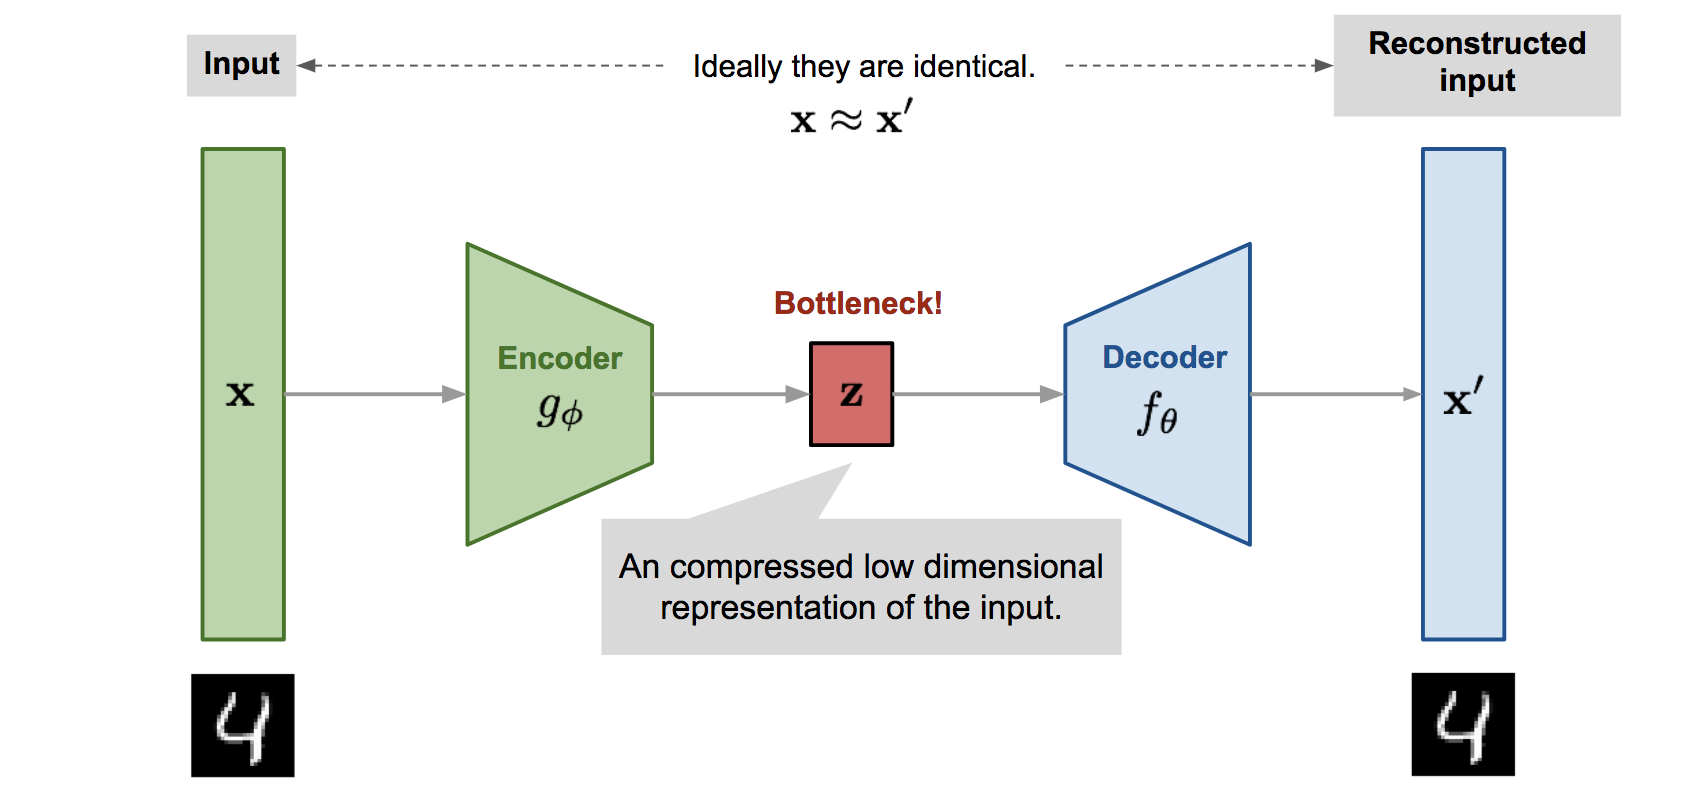

**The encoder network essentially accomplishes the dimensionality reduction, just like how we would use Principal Component Analysis (PCA) or Matrix Factorization (MF)**. In addition, the autoencoder is explicitly optimized for the data reconstruction from the code. A good intermediate representation not only can capture latent variables, but also benefits a full decompression process.

The model contains an encoder function $g(.)$ parameterized by $\phi$ and a decoder function $f(.)$ parameterized by $\theta$. The low-dimensional code learned for input $x$ in the bottleneck layer is $\mathbf{z} = g_\phi(\mathbf{x})$ and the reconstructed input is $\mathbf{x}’ = f_\theta(g_\phi(\mathbf{x}))$

The parameters $(\theta, \phi)$ are learned together to output a reconstructed data sample same as the original input, $\mathbf{x} \approx f_\theta(g_\phi(\mathbf{x}))$, or in other words, to learn an identity function. There are various metrics to quantify the difference between two vectors, such as cross entropy when the activation function is sigmoid, or as simple as MSE loss:

$$L_\text{AE}(\theta, \phi) = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})))^2$$



## Denoising Autoencoder

Since the autoencoder learns the identity function, we are facing the risk of “overfitting” when there are more network parameters than the number of data points.

To avoid overfitting and improve the robustness, Denoising Autoencoder (Vincent et al. 2008) proposed a modification to the basic autoencoder. The input is partially corrupted by adding noises to or masking some values of the input vector in a stochastic manner, $\tilde{\mathbf{x}} \sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$. Then the model is trained to recover the original input (note: not the corrupt one).

$$\begin{aligned}
\tilde{\mathbf{x}}^{(i)} &\sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}}^{(i)} \vert \mathbf{x}^{(i)})\\
L_\text{DAE}(\theta, \phi) &= \frac{1}{n} \sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\tilde{\mathbf{x}}^{(i)})))^2
\end{aligned}$$

where $\mathcal{M}_\mathcal{D}$ defines the mapping from the true data samples to the noisy or corrupted ones.

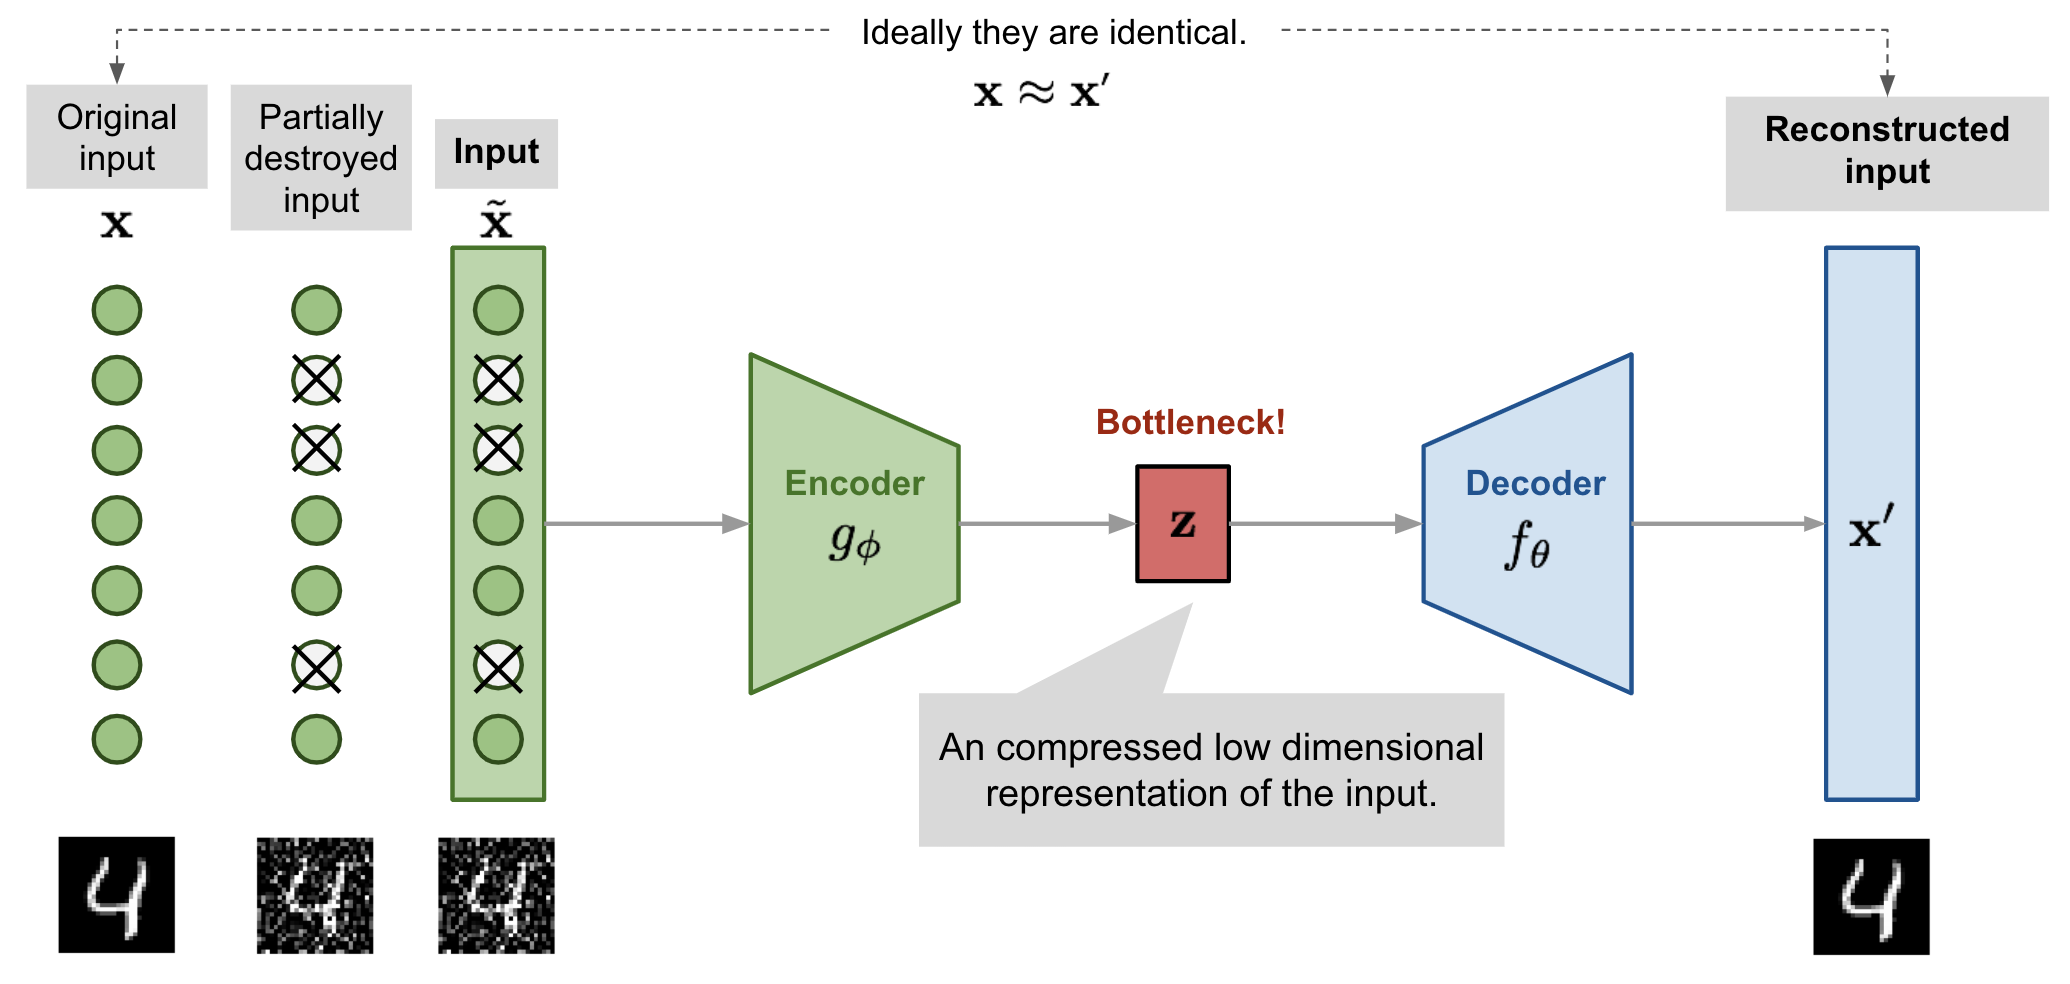


This design is motivated by the fact that humans can easily recognize an object or a scene even the view is partially occluded or corrupted. To “repair” the partially destroyed input, the denoising autoencoder has to discover and capture relationship between dimensions of input in order to infer missing pieces.

For high dimensional input with high redundancy, like images, the model is likely to depend on evidence gathered from a combination of many input dimensions to recover the denoised version rather than to overfit one dimension. This builds up a good foundation for learning robust latent representation.

The noise is controlled by a stochastic mapping $$\mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$$, and it is not specific to a particular type of corruption process (i.e. masking noise, Gaussian noise, salt-and-pepper noise, etc.). Naturally the corruption process can be equipped with prior knowledge

In the experiment of the original DAE paper, the noise is applied in this way: a fixed proportion of input dimensions are selected at random and their values are forced to 0. Sounds a lot like dropout, right? Well, the denoising autoencoder was proposed in 2008, 4 years before the dropout paper (Hinton, et al. 2012) ;)


In [ ]:
import tensorflow as tf
import keras

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def show_image(image):
    #im = plt.imshow(image, cmap='viridis')
    plt.figure(figsize=(8,2.5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def show_grid_images_labels_title(images, labels, columns, rows, title, start_index=0):
    fig = plt.figure(figsize=(10,2.5))
    
    
    for i in range(1, columns*rows + 1):
        img = images[i + start_index]
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(f'{labels[i + start_index]}')
        plt.axis('off')
        plt.imshow(img)
    
    fig.suptitle(f'{title}')
    plt.show()    

In [ ]:
show_grid_images_labels_title(x_train, y_train, columns=5, rows=1, title='Train')
show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Test')

In [ ]:
import numpy as np

np.random.seed(42)

def add_gaussian_noise(image, mean=0, std=1):
    """
    Add Gaussian noise to a binary image.

    Parameters:
    - image: Binary image of shape (28, 28).
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.
    
    Returns:
    - Noisy image.
    """
    gaussian_noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + gaussian_noise
    return noisy_image


def add_gaussian_noise_images(images, mean=0, std=1):
    noisy_images = [add_gaussian_noise(images[i], mean=mean, std=std) for i in range(len(images))]
    return np.array(noisy_images)

In [ ]:
# Generar las imagenes ruidosas
x_train_noisy = add_gaussian_noise_images(x_train, mean=0, std=0.4)
x_test_noisy = add_gaussian_noise_images(x_test, mean=0, std=0.4)

# Clipear las imagenes ruidosas
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

# Mostrar las imagenes Train y Train - Noise
show_grid_images_labels_title(x_train, y_train, columns=5, rows=1, title='Train')
show_grid_images_labels_title(x_train_noisy, y_train, columns=5, rows=1, title='Train - Noise')

# Mostrar las imagenes Test y Test - Noise
show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Tets')
show_grid_images_labels_title(x_test_noisy, y_test, columns=5, rows=1, title='Test - Noise')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

latent_dim = 64 

class Autoencoder(Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim 
        
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(
    x_train_noisy,  # Imágenes ruidosas como entrada
    x_train,        # Imágenes limpias como objetivos
    epochs=100,     # Número de épocas
    batch_size=128, # Tamaño del batch
    shuffle=True,   # Mezclar los datos en cada época
    validation_data=(x_test_noisy, x_test)  # También puedes proporcionar datos de prueba para evaluar.
)

In [ ]:
autoencoder.encoder.summary()

In [ ]:
autoencoder.decoder.summary()

In [ ]:
predict_test = autoencoder.predict([x_test_noisy])

In [ ]:
show_grid_images_labels_title(x_test, y_test, columns=6, rows=1, title='Tests - Original')
show_grid_images_labels_title(x_test_noisy, y_test, columns=6, rows=1, title='Test - Noise')
show_grid_images_labels_title(predict_test, y_test, columns=6, rows=1, title='Test - Predicted')

## Sparse Autoencoder

Sparse Autoencoder applies a “sparse” constraint on the hidden unit activation to avoid overfitting and improve robustness. It forces the model to only have a small number of hidden units being activated at the same time, or in other words, one hidden neuron should be inactivate most of time.

Recall that common activation functions include sigmoid, tanh, relu, leaky relu, etc. A neuron is activated when the value is close to 1 and inactivate with a value close to 0.

Let’s say there are $s_l$ neurons in the $l$-th hidden layer and the activation function for the $j$-th neuron in this layer is labelled as $a^{(l)}_j(.)$, $j=1, \dots, s_l$. The fraction of activation of this neuron $\hat{\rho}_j$ is expected to be a small number $\rho$, known as sparsity parameter; a common config is $\rho = 0.05$.

$$\hat{\rho}_j^{(l)} = \frac{1}{n} \sum_{i=1}^n [a_j^{(l)}(\mathbf{x}^{(i)})] \approx \rho$$

This constraint is achieved by adding a penalty term into the loss function. The KL-divergence $D_\text{KL}$ measures the difference between two Bernoulli distributions, one with mean $\rho$ and the other with mean $\hat{\rho}_j^{(l)}$. The hyperparameter $\beta$ controls how strong the penalty we want to apply on the sparsity loss.

$$\begin{aligned}
L_\text{SAE}(\theta) 
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} D_\text{KL}(\rho \| \hat{\rho}_j^{(l)}) \\
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} \rho\log\frac{\rho}{\hat{\rho}_j^{(l)}} + (1-\rho)\log\frac{1-\rho}{1-\hat{\rho}_j^{(l)}}
\end{aligned}$$



> Las fórmulas describen cómo se implementa el concepto de dispersión (sparsity) en un autoencoder disperso (Sparse Autoencoder, SAE) para regular la activación de las neuronas en las capas ocultas, con el fin de prevenir el sobreajuste y mejorar la robustez del modelo. Vamos a desglosar y explicar cada parte de estas ecuaciones:

> $\hat{\rho}_j^{(l)}$: Tasa promedio de activación de una neurona

> Esta fórmula calcula el promedio de activación (o tasa de activación) de la $j$-ésima neurona en la capa oculta $l$-ésima, $\hat{\rho}_j^{(l)}$. Se obtiene promediando las activaciones de la neurona $j$-ésima sobre $n$ ejemplos de entrenamiento, donde $a_j^{(l)}(\mathbf{x}^{(i)})$ representa la activación de la neurona $j$-ésima para el $i$-ésimo ejemplo de entrada $\mathbf{x}^{(i)}$. La idea es que esta tasa de activación sea cercana a un pequeño valor $\rho$ (por ejemplo, $\rho=0.05$), lo que indica que cada neurona debería estar inactiva (cercana a 0) la mayoría del tiempo, y solo activarse (cercana a 1) para una pequeña fracción de los ejemplos de entrenamiento.
Restricción de dispersión mediante la divergencia de Kullback-Leibler (KL)

> La divergencia de KL, $D_\text{KL}(\rho | \hat{\rho}_j^{(l)})$, mide la diferencia entre dos distribuciones de Bernoulli: una con media $\rho$ (el parámetro de dispersión deseado) y otra con media $\hat{\rho}_j^{(l)}$ (la tasa de activación promedio observada para la neurona $j$). La fórmula $\rho\log\frac{\rho}{\hat{\rho}_j^{(l)}} + (1-\rho)\log\frac{1-\rho}{1-\hat{\rho}_j^{(l)}}$ representa esta divergencia, cuantificando cuánto se desvía la activación real de la neurona de la activación deseada $\rho$. El objetivo es minimizar esta divergencia para cada neurona, forzando así que las activaciones se acerquen al valor deseado de dispersión $\rho$.
Función de pérdida del autoencoder disperso $L_\text{SAE}(\theta)$

> La función de pérdida total del autoencoder disperso, $L_\text{SAE}(\theta)$, se compone de dos términos:
$L(\theta)$: La pérdida de reconstrucción, que mide qué tan bien el autoencoder puede reconstruir los datos de entrada después de comprimirlos en una representación más compacta. Esta parte asegura que, a pesar de la dispersión, el modelo aún aprende a capturar la estructura esencial de los datos de entrada.
El segundo término es la suma ponderada de las divergencias de KL para todas las neuronas en todas las capas ocultas, multiplicada por un hiperparámetro $\beta$. Este término impone la restricción de dispersión, penalizando las desviaciones de la tasa de activación promedio $\hat{\rho}_j^{(l)}$ del valor deseado $\rho$. El hiperparámetro $\beta$ controla la importancia de la restricción de dispersión en la función de pérdida total: un valor más alto de $\beta$ hace que el modelo priorice más fuertemente el cumplimiento de la restricción de dispersión.
En resumen, estas fórmulas describen cómo un autoencoder disperso implementa y aplica la restricción de dispersión para asegurar que solo un pequeño número de neuronas en las capas ocultas se active para cualquier ejemplo dado, lo que ayuda a mejorar la generalización y robustez del modelo al evitar que se sobreajuste a los datos de entrenamiento.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Layer


class SparseAutoencoder(Model):
    def __init__(self, latent_dim, sparsity_level=0.05, sparsity_weight=0.1):
        super(SparseAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='sigmoid'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])
        self.reconstruction_loss_layer = MSEDecoderLossLayer() # MSE Decoder (resultado)
        self.sparsity_loss_layer = SparsityLossLayer(
            sparsity_level=sparsity_level, 
            sparsity_weight=sparsity_weight) # Sparsity loss

    def call(self, inputs):
        encoded = self.encoder(inputs)
        encoded_with_loss = self.sparsity_loss_layer(encoded)  # Añade la pérdida de escasez
        decoded = self.decoder(encoded_with_loss)
        _ = self.reconstruction_loss_layer(inputs, decoded)  # Añade la pérdida de reconstrucción
        return decoded
    

class MSEDecoderLossLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, outputs):
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))
        self.add_loss(reconstruction_loss) # Add loss
        return outputs  # Esta capa no altera los outputs, solo añade una pérdida
    
class SparsityLossLayer(Layer):
    def __init__(self, sparsity_level=0.05, sparsity_weight=0.1, **kwargs):
        super().__init__(**kwargs)
        self.sparsity_level = sparsity_level
        self.sparsity_weight = sparsity_weight

    def call(self, inputs):
        # Calcular la densidad promedio de activación para cada unidad
        rho_hat = tf.reduce_mean(inputs, axis=0)
        
        # Calcular la divergencia KL
        kl_divergence = self.sparsity_level * tf.math.log(self.sparsity_level / (rho_hat + 1e-10)) + \
            (1 - self.sparsity_level) * tf.math.log((1 - self.sparsity_level) / (1 - rho_hat + 1e-10))
        kl_divergence = tf.reduce_sum(kl_divergence)  # Suma sobre todas las unidades
        
        # Añadir la pérdida de dispersión, ponderada por sparsity_weight, al modelo
        self.add_loss(self.sparsity_weight * kl_divergence)
        return inputs  # Pasar las activaciones a través de sin cambios

> Durante el entrenamiento, tensorflow suma todos los loss de `.add_loss`, por eso se añade el `sparsity_weight`, para controlar el peso de este loss.

In [ ]:
sparse_autoencoder = SparseAutoencoder(latent_dim=64, sparsity_level=0.01, sparsity_weight=0.2)

In [ ]:
sparse_autoencoder.compile(optimizer='adam')

In [ ]:
sparse_autoencoder.fit(
    x_train,        # Imágenes limpias como entrada
    x_train,        # Imágenes limpias como objetivos
    epochs=50,     # Número de épocas
    batch_size=128, # Tamaño del batch
    shuffle=True,   # Mezclar los datos en cada época
    validation_data=(x_test, x_test)  # También puedes proporcionar datos de prueba para evaluar.
)

In [ ]:
encoder_activations = sparse_autoencoder.encoder(x_test).numpy()

In [ ]:
import matplotlib.pyplot as plt

def plot_activation_histograms(activations):
    """
    Dibuja un histograma de las activaciones de las neuronas en la capa de encoder.
    
    Args:
    - activations (numpy.ndarray): Las activaciones de la capa de encoder.
    """
    # Histograma de todas las activaciones
    plt.figure(figsize=(10, 6))
    activations_flat = activations.flatten()
    plt.hist(activations_flat, bins=100, alpha=0.75)
    plt.title('Histograma de Todas las Activaciones de la Capa de Encoder')
    plt.xlabel('Valor de Activación')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
plot_activation_histograms(encoder_activations)

In [ ]:
def compare_sparsity_effects(autoencoder_class, x_train, x_test, sparsity_level_sparsity_weight_pairs):
    """
    Entrena y visualiza las activaciones de la capa de encoder para diferentes valores de sparsity_level y sparsity_weight,
    todo en la misma gráfica con distintos colores.

    Args:
    - autoencoder_class (class): La clase de tu SparseAutoencoder, no una instancia.
    - x_train (numpy.ndarray): Datos de entrenamiento.
    - x_test (numpy.ndarray): Datos de prueba para generar activaciones.
    - sparsity_level_sparsity_weight_pairs (list of tuples): Lista de tuplas (sparsity_level, sparsity_weight) para probar.
    """
    plt.figure(figsize=(10, 6))
    for sparsity_level, sparsity_weight in sparsity_level_sparsity_weight_pairs:
        print(f"Entrenando con sparsity_level={sparsity_level}, sparsity_weight={sparsity_weight}...")
        # Crea una nueva instancia del autoencoder con los parámetros actuales
        model_clone = autoencoder_class(latent_dim=64, sparsity_level=sparsity_level, sparsity_weight=sparsity_weight)
        model_clone.compile(optimizer='adam')
        
        # Entrenar el modelo. Considera usar un número reducido de epochs para demostraciones.
        model_clone.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, verbose=0)  # Ajusta epochs según necesidad
        
        # Obtener activaciones de la capa de encoder
        encoder_activations = model_clone.encoder(x_test).numpy().flatten()
        
        # Dibujar histograma de las activaciones
        plt.hist(encoder_activations, bins=100, alpha=0.5, label=f"sparsity_level={sparsity_level}, weight={sparsity_weight}")

    plt.title('Comparación de Activaciones de la Capa de Encoder')
    plt.xlabel('Valor de Activación')
    plt.ylabel('Frecuencia')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
# Asume que sparse_autoencoder es tu modelo, x_train tus datos de entrenamiento y x_test tus datos de prueba
sparsity_level_sparsity_weight_pairs = [(0.01, 1), (0.05, 1), (0.1, 1)]  # Ejemplos de pares de rho y beta para probar
compare_sparsity_effects(SparseAutoencoder, x_train, x_test, sparsity_level_sparsity_weight_pairs)

sparsity_level_sparsity_weight_pairs = [(0.01, 0.1), (0.01, 0.5), (0.01, 1), (0.01, 2), (0.01, 10)]
compare_sparsity_effects(SparseAutoencoder, x_train, x_test, sparsity_level_sparsity_weight_pairs)

In [ ]:
predict_test = sparse_autoencoder.predict([x_test])

In [ ]:
show_grid_images_labels_title(x_test, y_test, columns=5, rows=1, title='Test')
show_grid_images_labels_title(predict_test, y_test, columns=5, rows=1, title='Test - Sparsed')

# Contractive Autoencoder

Similar to sparse autoencoder, Contractive Autoencoder (Rifai, et al, 2011) encourages the learned representation to stay in a contractive space for better robustness.

It adds a term in the loss function to penalize the representation being too sensitive to the input, and thus improve the robustness to small perturbations around the training data points. The sensitivity is measured by the Frobenius norm of the Jacobian matrix of the encoder activations with respect to the input:

$$\|J_f(\mathbf{x})\|_F^2 = \sum_{ij} \Big( \frac{\partial h_j(\mathbf{x})}{\partial x_i} \Big)^2$$
 
where $h_j$ is one unit output in the compressed code $\mathbf{z} = f(x)$.

This penalty term is the sum of squares of all partial derivatives of the learned encoding with respect to input dimensions. The authors claimed that empirically this penalty was found to carve a representation that corresponds to a lower-dimensional non-linear manifold, while staying more invariant to majority directions orthogonal to the manifold.

# VAE: Variational Autoencoder

The idea of Variational Autoencoder (Kingma & Welling, 2014), short for VAE, is actually less similar to all the autoencoder models above, but deeply rooted in the methods of variational bayesian and graphical model.

Instead of mapping the input into a fixed vector, we want to map it into a distribution. Let’s label this distribution as $p_\theta$, parameterized by $\theta$. The relationship between the data input $\mathbf{x}$ and the latent encoding vector $\mathbf{z}$ can be fully defined by:

* Prior $p_\theta(\mathbf{z})$
* Likelihood $p_\theta(\mathbf{x}\vert\mathbf{z})$
* Posterior $p_\theta(\mathbf{z}\vert\mathbf{x})$

Assuming that we know the real parameter $\theta^{*}$ for this distribution. In order to generate a sample that looks like a real data point $\mathbf{x}^{(i)}$, we follow these steps:

1. First, sample a $\mathbf{z}^{(i)}$ from a prior distribution $p_{\theta^*}(\mathbf{z})$.
2. Then a value $\mathbf{x}^{(i)}$ is generated from a conditional distribution $p_{\theta^*}(\mathbf{x} \vert \mathbf{z} = \mathbf{z}^{(i)})$.

The optimal parameter $\theta^{*}$ is the one that maximizes the probability of generating real data samples:

$$\theta^{*} = \arg\max_\theta \prod_{i=1}^n p_\theta(\mathbf{x}^{(i)})$$

Commonly we use the log probabilities to convert the product on RHS to a sum:

$$\theta^{*} = \arg\max_\theta \sum_{i=1}^n \log p_\theta(\mathbf{x}^{(i)})$$

Now let’s update the equation to better demonstrate the data generation process so as to involve the encoding vector:

$$p_\theta(\mathbf{x}^{(i)}) = \int p_\theta(\mathbf{x}^{(i)}\vert\mathbf{z}) p_\theta(\mathbf{z}) d\mathbf{z}$$

Unfortunately it is not easy to compute $p_\theta(\mathbf{x}^{(i)})$ in this way, as it is very expensive to check all the possible values of $\mathbf{z}$ and sum them up. To narrow down the value space to facilitate faster search, we would like to introduce a new approximation function to output what is a likely code given an input $\mathbf{x}$, $q_\phi(\mathbf{z}\vert\mathbf{x})$, parameterized by $\phi$.

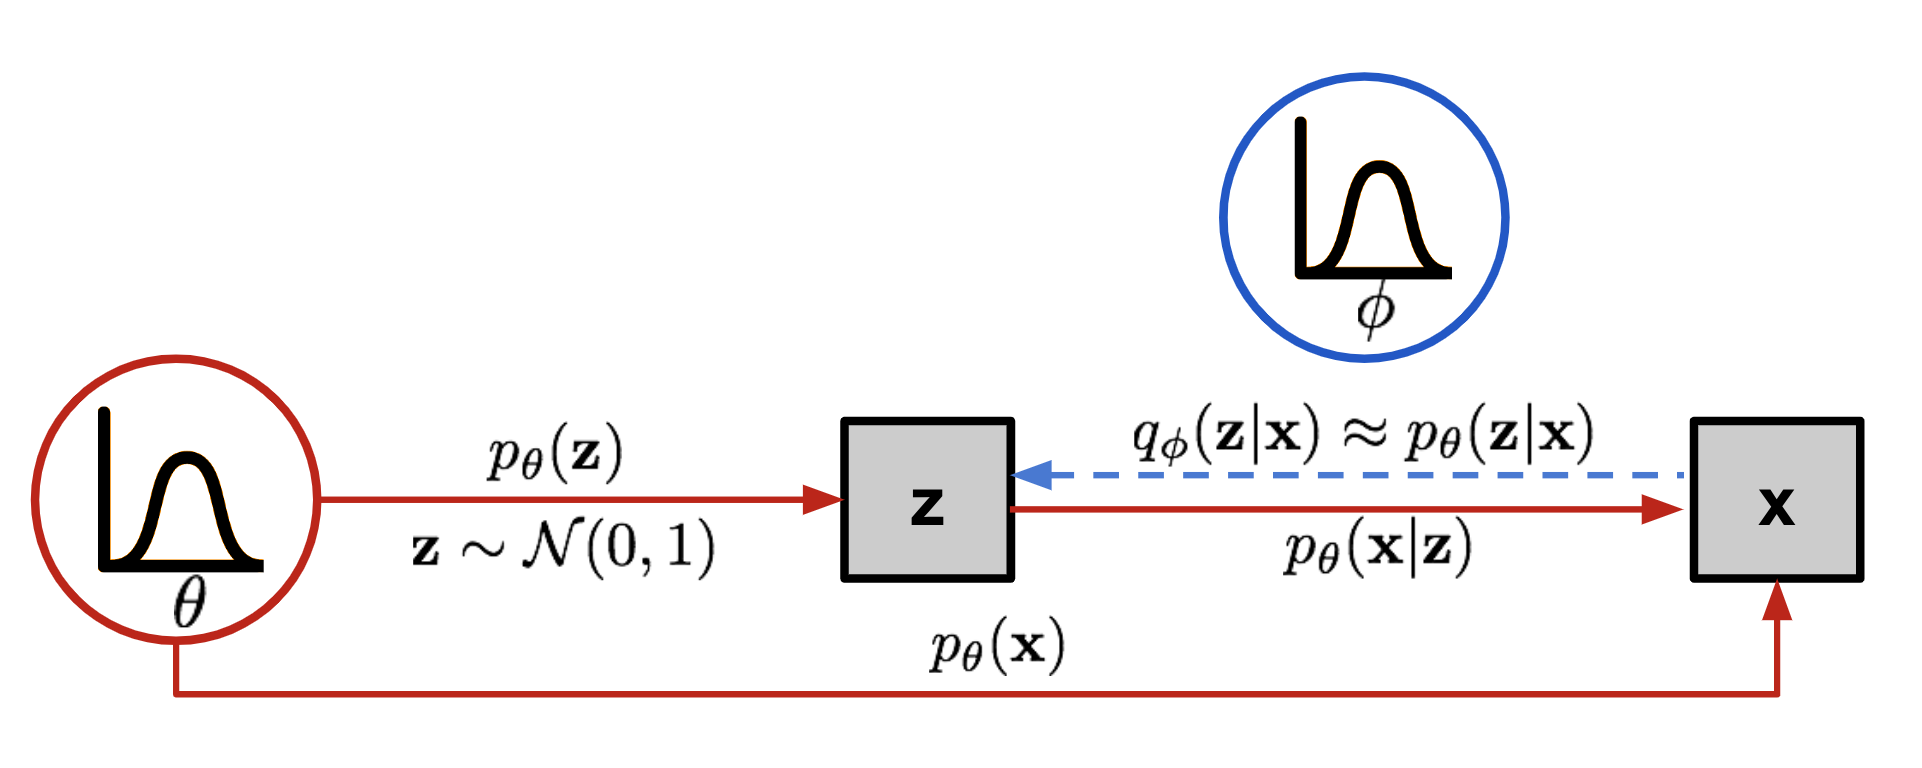

Now the structure looks a lot like an autoencoder:

- The conditional probability $p_\theta(\mathbf{x} \vert \mathbf{z})$ defines a generative model, similar to the decoder $f_\theta(\mathbf{x} \vert \mathbf{z})$ introduced above. $p_\theta(\mathbf{x} \vert \mathbf{z})$ is also known as probabilistic decoder.
- The approximation function $q_\phi(\mathbf{z} \vert \mathbf{x})$ is the probabilistic encoder, playing a similar role as $g_\phi(\mathbf{z} \vert \mathbf{x})$ above.


## Loss Function: ELBO

The estimated posterior $q_\phi(\mathbf{z}\vert\mathbf{x})$ should be very close to the real one $p_\theta(\mathbf{z}\vert\mathbf{x})$. We can use Kullback-Leibler divergence to quantify the distance between these two distributions. KL divergence $D_\text{KL}(X|Y)$ measures how much information is lost if the distribution Y is used to represent X.

In our case we want to minimize $D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) | p_\theta(\mathbf{z}\vert\mathbf{x}) )$ with respect to $\phi$.

But why use $D_\text{KL}(q_\phi | p_\theta)$ (reversed KL) instead of $D_\text{KL}(p_\theta | q_\phi)$  (forward KL)? Eric Jang has a great explanation in his post on Bayesian Variational methods. As a quick recap:

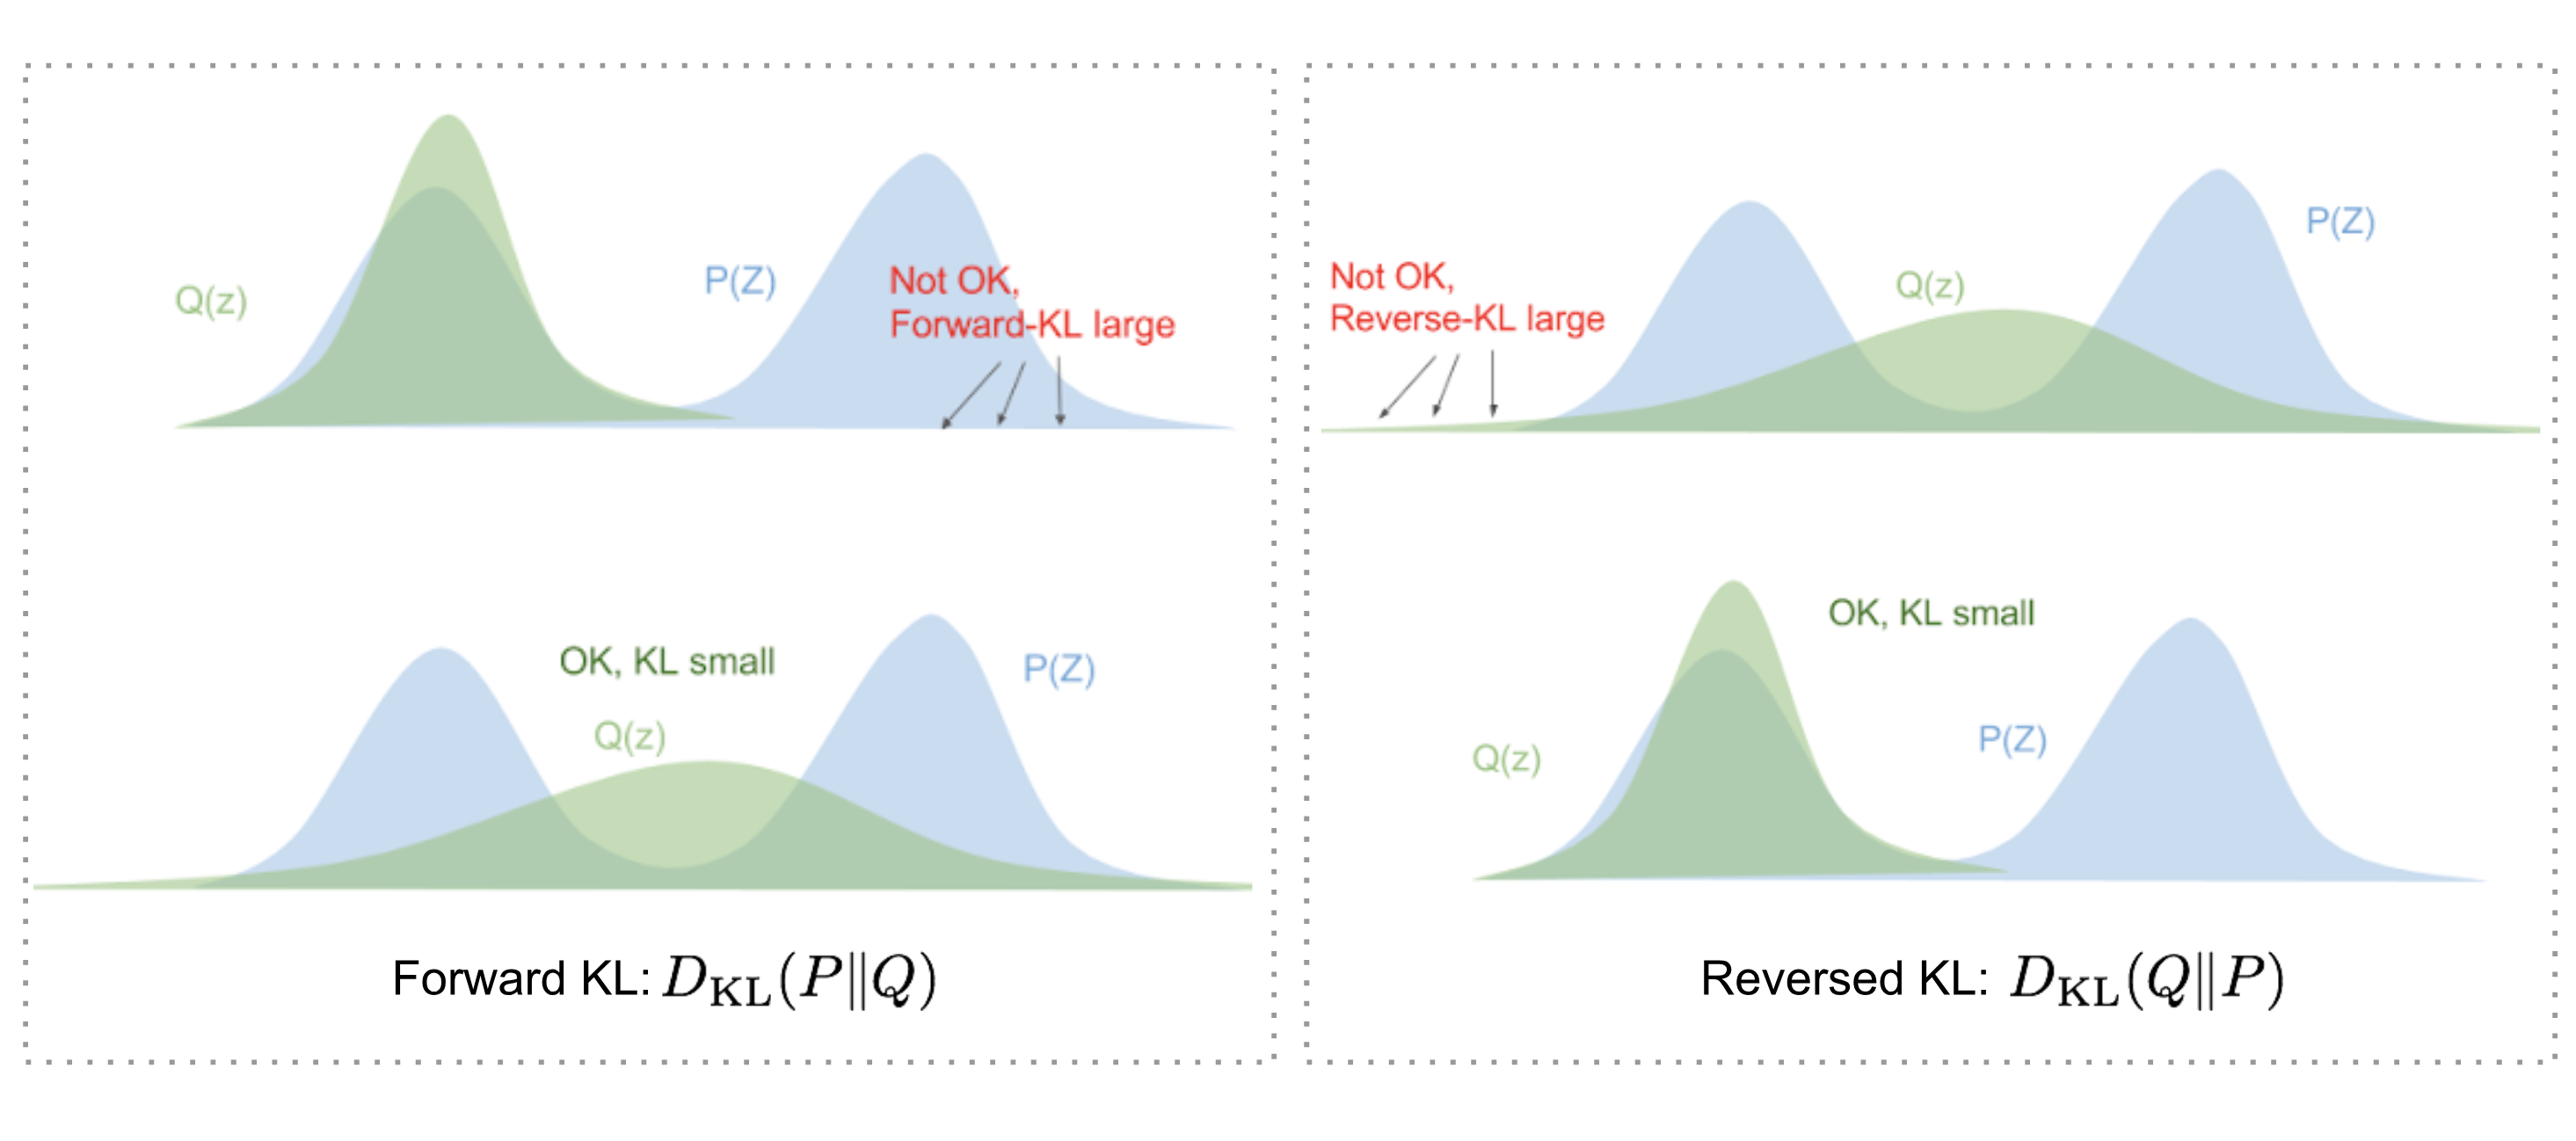


Forward KL divergence: $D_\text{KL}(P|Q) = \mathbb{E}_{z\sim P(z)} \log\frac{P(z)}{Q(z)}$; we have to ensure that Q(z)>0 wherever P(z)>0. The optimized variational distribution $q(z)$ has to cover over the entire $p(z)$.
Reversed KL divergence: $D_\text{KL}(Q|P) = \mathbb{E}_{z\sim Q(z)} \log\frac{Q(z)}{P(z)}$; minimizing the reversed KL divergence squeezes the $Q(z)$ under $P(z)$.

Let’s now expand the equation:

$$\begin{aligned}
& D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) ) & \\
&=\int q_\phi(\mathbf{z} \vert \mathbf{x}) \log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{z} \vert \mathbf{x})} d\mathbf{z} & \\
&=\int q_\phi(\mathbf{z} \vert \mathbf{x}) \log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})p_\theta(\mathbf{x})}{p_\theta(\mathbf{z}, \mathbf{x})} d\mathbf{z} & \scriptstyle{\text{; Because }p(z \vert x) = p(z, x) / p(x)} \\
&=\int q_\phi(\mathbf{z} \vert \mathbf{x}) \big( \log p_\theta(\mathbf{x}) + \log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{z}, \mathbf{x})} \big) d\mathbf{z} & \\
&=\log p_\theta(\mathbf{x}) + \int q_\phi(\mathbf{z} \vert \mathbf{x})\log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{z}, \mathbf{x})} d\mathbf{z} & \scriptstyle{\text{; Because }\int q(z \vert x) dz = 1}\\
&=\log p_\theta(\mathbf{x}) + \int q_\phi(\mathbf{z} \vert \mathbf{x})\log\frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{x}\vert\mathbf{z})p_\theta(\mathbf{z})} d\mathbf{z} & \scriptstyle{\text{; Because }p(z, x) = p(x \vert z) p(z)} \\
&=\log p_\theta(\mathbf{x}) + \mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z} \vert \mathbf{x})}[\log \frac{q_\phi(\mathbf{z} \vert \mathbf{x})}{p_\theta(\mathbf{z})} - \log p_\theta(\mathbf{x} \vert \mathbf{z})] &\\
&=\log p_\theta(\mathbf{x}) + D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z})) - \mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z}\vert\mathbf{x})}\log p_\theta(\mathbf{x}\vert\mathbf{z}) &
\end{aligned}$$

So we have:

$$D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) ) =\log p_\theta(\mathbf{x}) + D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z})) - \mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z}\vert\mathbf{x})}\log p_\theta(\mathbf{x}\vert\mathbf{z})$$

Once rearrange the left and right hand side of the equation,


$$\log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) ) = \mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z}\vert\mathbf{x})}\log p_\theta(\mathbf{x}\vert\mathbf{z}) - D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}))$$

The LHS of the equation is exactly what we want to maximize when learning the true distributions: we want to maximize the (log-)likelihood of generating real data (that is $\log p_\theta(\mathbf{x})$) and also minimize the difference between the real and estimated posterior distributions (the term $p_\theta(\mathbf{x})$ works like a regularizer). Note that $p_\theta(\mathbf{x})$ is fixed with respect to $q_\phi$.

The negation of the above defines our loss function:

$$\begin{aligned}
L_\text{VAE}(\theta, \phi) 
&= -\log p_\theta(\mathbf{x}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) )\\
&= - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\
\theta^{*}, \phi^{*} &= \arg\min_{\theta, \phi} L_\text{VAE}
\end{aligned}$$


In Variational Bayesian methods, this loss function is known as the variational lower bound, or evidence lower bound. The “lower bound” part in the name comes from the fact that KL divergence is always non-negative and thus $-L_\text{VAE}$ is the lower bound of $\log p_\theta (\mathbf{x})$.

$$-L_\text{VAE} = \log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) ) \leq \log p_\theta(\mathbf{x})$$

Therefore by minimizing the loss, we are maximizing the lower bound of the probability of generating real data samples.

## Reparameterization Trick

The expectation term in the loss function invokes generating samples from $\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})$. Sampling is a stochastic process and therefore we cannot backpropagate the gradient. To make it trainable, the reparameterization trick is introduced: It is often possible to express the random variable $\mathbf{z}$ as a deterministic variable $\mathbf{z} = \mathcal{T}_\phi(\mathbf{x}, \boldsymbol{\epsilon})$, where $\boldsymbol{\epsilon}$ is an auxiliary independent random variable, and the transformation function $\mathcal{T}_\phi$ parameterized by $\mathcal{T}_\phi$ converts $\boldsymbol{\epsilon}$ to $\mathbf{z}$.

For example, a common choice of the form of $q_\phi(\mathbf{z}\vert\mathbf{x})$ is a multivariate Gaussian with a diagonal covariance structure:

$$\begin{aligned}
\mathbf{z} &\sim q_\phi(\mathbf{z}\vert\mathbf{x}^{(i)}) = \mathcal{N}(\mathbf{z}; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)}\boldsymbol{I}) & \\
\mathbf{z} &= \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon} \text{, where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I}) & \scriptstyle{\text{; Reparameterization trick.}}
\end{aligned}$$

where $\odot$ refers to element-wise product.


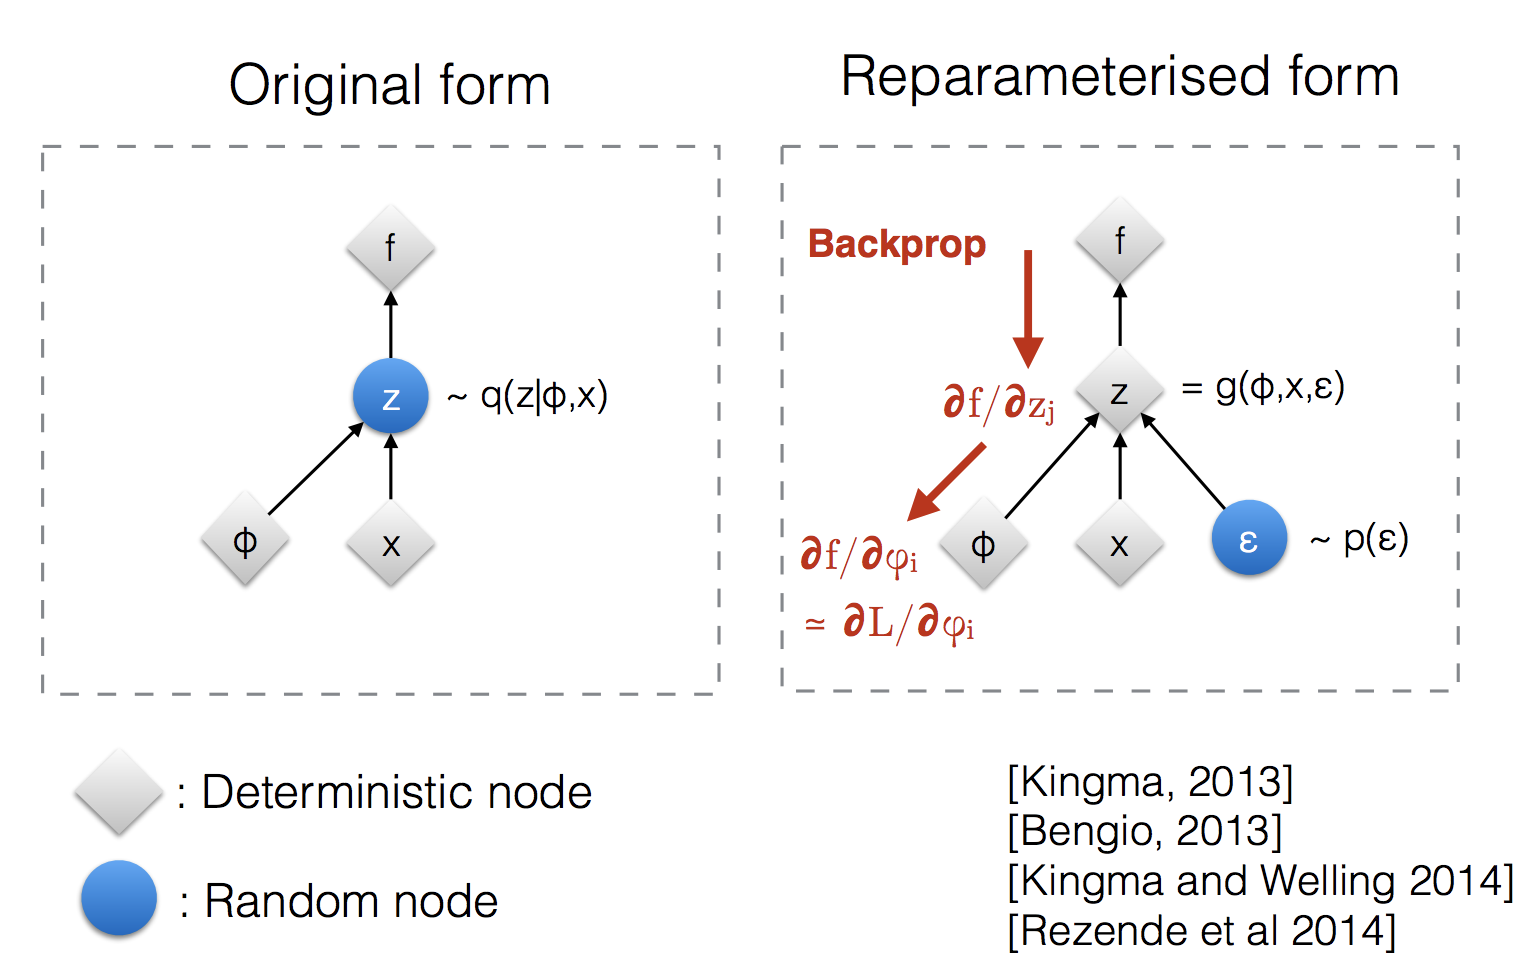

The reparameterization trick works for other types of distributions too, not only Gaussian. In the multivariate Gaussian case, we make the model trainable by learning the mean and variance of the distribution, $\mu$ and $\sigma$, explicitly using the reparameterization trick, while the stochasticity remains in the random variable $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I})$.

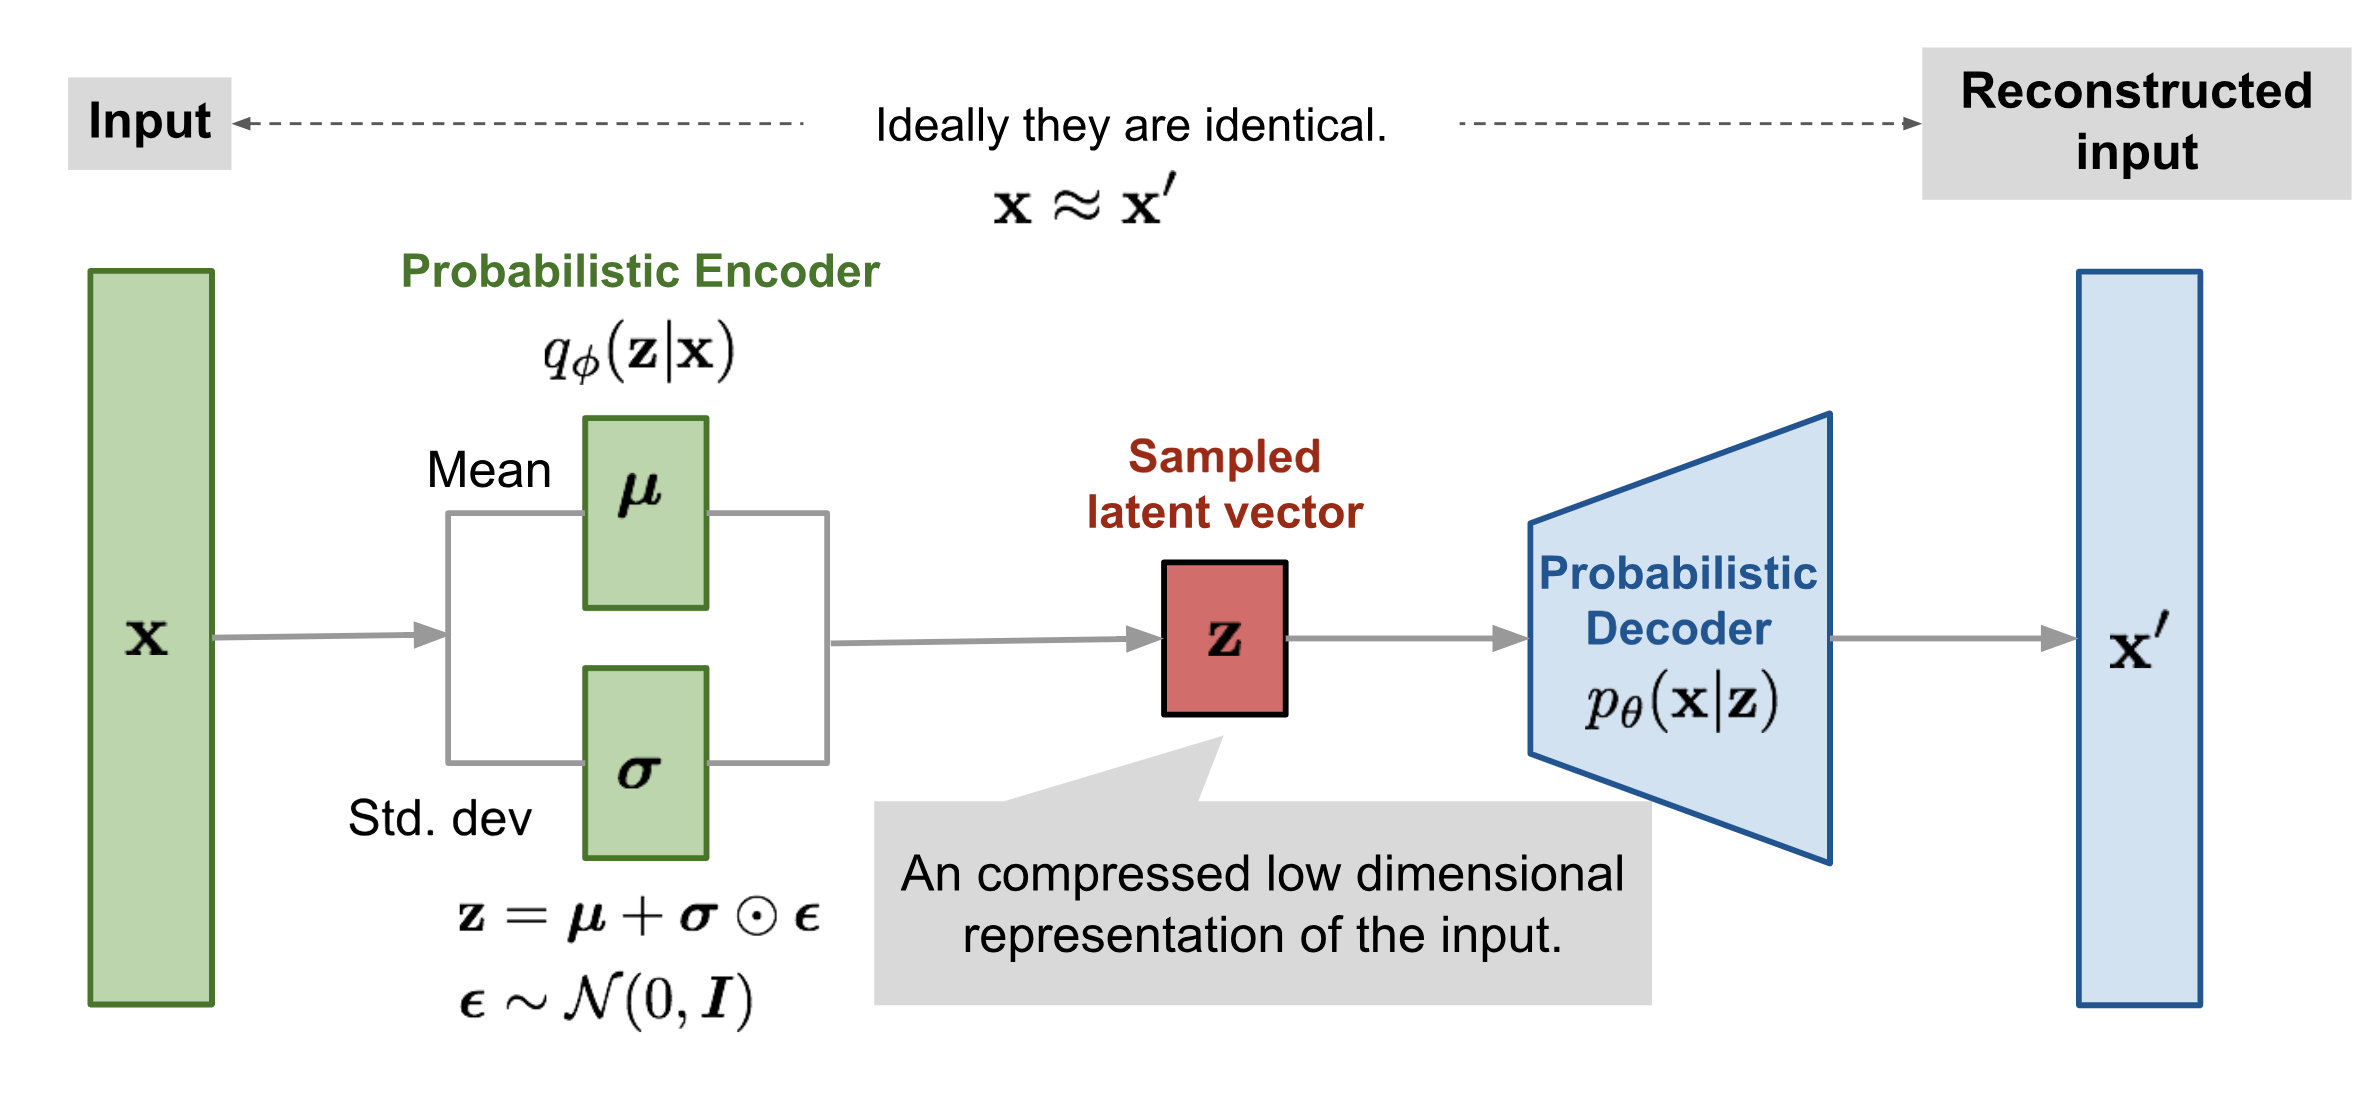




In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras import backend as K

class VariationalAutoEncoder(Model):
    
    def __init__(self, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
    
    def build_encoder(self):
        inputs = keras.Input(shape=(28, 28, 1))
        
        x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
        x = Flatten()(x)
        x = Dense(16, activation='relu')(x)
        
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        
        return Model(inputs, [z_mean, z_log_var], name='encoder')
    

    def build_decoder(self):

        latent_inputs = keras.Input(shape=(self.latent_dim,))
        
        x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
        x = Reshape((7, 7, 64))(x)
        x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        
        outputs = Conv2DTranspose(1, 3, activation='sigmoid', strides=2, padding='same')(x)
                
        return Model(latent_inputs, outputs, name='decoder')

        
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        
        return reconstructed    
    
    def reparameterize(self, mean, log_var):
        epsilon = K.random_normal(shape=(mean.shape[0], self.latent_dim))
        return mean + K.exp(0.5 * log_var) * epsilon

    def compute_loss(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        
        # Pérdida de reconstrucción
        reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(reconstructed))
        reconstruction_loss *= 28 * 28
        
        # Pérdida KL
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        # Pérdida total
        total_loss = K.mean(reconstruction_loss + kl_loss)
        return total_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {'loss': loss}


In [ ]:
from tensorflow.keras.optimizers import Adam

vae = VariationalAutoEncoder(latent_dim=50)
vae.compile(optimizer=Adam(learning_rate=0.01))

In [ ]:
x_train_vae = x_train.reshape(list(x_train.shape) + [1]) 
x_test_vae = x_test.reshape(list(x_test.shape) + [1]) 
x_train_vae[0].shape

In [ ]:
# Suponiendo que `x_train` son tus datos normalizados de MNIST
vae.fit(x_train_vae, epochs=100, batch_size=32)

In [ ]:
x_example = np.array([x_train_vae[0]])

_ = vae(x_example)
_

In [ ]:
vae.save_weights('pesos_mi_modelo_vae.h5')

In [ ]:
nuevo_vae = VariationalAutoEncoder(latent_dim=50)  # Asume la misma arquitectura

input_ejemplo = np.random.random((1, 28, 28, 1)).astype(np.float32)  # Un ejemplo aleatorio
nuevo_vae(input_ejemplo)  # Llama al modelo con el input de ejemplo para inicializar las variables


nuevo_vae.load_weights('pesos_mi_modelo_vae.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reconstructions(model, data, n=10):
    """
    Visualiza las reconstrucciones junto a las imágenes originales.
    
    Parámetros:
    - model: el modelo VAE entrenado.
    - data: conjunto de datos de imágenes para reconstruir.
    - n: número de imágenes a visualizar.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Selecciona una imagen al azar
        idx = np.random.randint(0, data.shape[0])
        img = data[idx]
        
        # Predice la reconstrucción de la imagen
        img = np.expand_dims(img, axis=0)  # Ajusta la forma para el modelo
        reconstruction = model(img)
        
        # Visualiza la imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(img[0].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Visualiza la imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruction[0].reshape(28, 28), cmap='gray')
        plt.title("Reconstruida")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
# Llamada a la función para visualizar las reconstrucciones
plot_reconstructions(nuevo_vae, x_test_vae)

In [ ]:
nuevo_vae.predict(x_test_vae[0])

In [ ]:
x_train_vae[0].shape